In [34]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
#Perform basic dimension check

#Read in full toxicity dataset
#data = pd.read_csv('toxicity_data_13.csv')
data = pd.read_csv('toxicity_data.csv')
print(data.columns)
features = data.columns

#Output dimensions of the data
print("Dimensions of toxicity data:")
print("Number of rows:", data.shape[0])
print("Number of columns:", data.shape[1])

Index(['MATS3v', 'nHBint10', 'MATS3s', 'MATS3p', 'nHBDon_Lipinski',
       'minHBint8', 'MATS3e', 'MATS3c', 'minHBint2', 'MATS3m',
       ...
       'WTPT-4', 'WTPT-5', 'ETA_EtaP_L', 'ETA_EtaP_F', 'ETA_EtaP_B', 'nT5Ring',
       'SHdNH', 'ETA_dEpsilon_C', 'MDEO-22', 'Class'],
      dtype='object', length=1204)
Dimensions of toxicity data:
Number of rows: 171
Number of columns: 1204


In [47]:
def sigmoid(z):
    return 1/(1+np.exp(-z))

In [37]:
def test_sigmoid():
    #Sample case
    test_inputs = [0, 1, -1, 10, -10]
    expected_outputs = [0.5, 0.73105858, 0.26894142, 0.9999546, 4.53978687e-05]
    for input_val, expected_output in zip(test_inputs, expected_outputs):
        output = sigmoid(input_val)
        assert np.isclose(output, expected_output), f"Test failed: Input {input_val}, Expected {expected_output}, Got {output}"

    print("Sigmoid function test passed.")
test_sigmoid()

Sigmoid function test passed.


In [51]:
def logistic_regression(X, y, learning_rate=0.001, n_iters=1000):
    """
    Fit logistic regression model to the data.
    """
    n_samples, n_features = X.shape

    #Initialize parameters
    weights = np.zeros(n_features)
    bias = 0

    #Gradient descent
    for _ in range(n_iters):
        # Linear combination of weights and features, plus bias
        linear_model = np.dot(X, weights) + bias
        # Apply sigmoid function
        y_predicted = sigmoid(linear_model)

        #Compute gradients
        dw = (1 / n_samples) * np.dot(X.T, (y_predicted - y))
        db = (1 / n_samples) * np.sum(y_predicted - y)        

        # Update parameters
        weights -= learning_rate * dw
        bias -= learning_rate * db

    return weights, bias

def logistic_regression_predict(X, weights, bias):
    """
    Predict using logistic regression model.
    """
    linear_model = np.dot(X, weights) + bias
    y_predicted = sigmoid(linear_model)
    y_predicted_cls = [1 if i > 0.5 else 0 for i in y_predicted]
    return np.array(y_predicted_cls)

def select_best_feature(X, y, selected_features):
    remaining_features = [i for i in range(X.shape[1]) if i not in selected_features]
    best_score = -np.inf
    best_feature = None

    for feature in remaining_features:
        X_temp = X[:, selected_features + [feature]]
        weights, bias, _ = logistic_regression(X_temp, y)

        linear_model = np.dot(X_temp, weights) + bias
        y_predicted = sigmoid(linear_model)

        score = compute_score(y, y_predicted)
        if score > best_score:
            best_score = score
            best_feature = feature

    return best_feature

def compute_score(y_true, y_pred):
    accuracy = np.sum(y_true == y_pred) / len(y_true)
    return accuracy

def standard_scaler(X):
    # Calculate the mean of each feature
    means = X.mean(axis=0)
    
    # Calculate the standard deviation of each feature
    stds = X.std(axis=0)
    
    # Apply standard scaling to each feature
    scaled_X = (X - means) / stds
    
    return scaled_X

In [49]:
def test_compute_score():
    #Test cases
    y_true = np.array([0, 1, 0, 1, 1])
    y_pred = np.array([0, 1, 0, 0, 1])
    expected_output = 0.8

    #Run
    output = compute_score(y_true, y_pred)
    assert np.isclose(output, expected_output), f"Test failed: Expected {expected_output}, Got {output}"

    print("Compute score function test passed.")
#test_compute_score()

In [50]:
#Log normalize the numerical data
#data = np.log1p(data)

#Toxicity data has class variable (toxic vs nontoxic) as target variable
X = data.drop('Class', axis=1) 
y = data['Class']


#Print XPortion
print("Input features for logistic regression (X):")
X = X.to_numpy()
print(X)
print(type(X))
#Print YPortion
print("Target variable for logistic regression:")
print(y.head())

#Convert target variable numeric
#0 FOR NONTOXIC
#1 FOR TOXIC
y_numeric = [0 if label == 'NonToxic' else 1 for label in y]
#Convert to numpy array
y_numeric = np.array(y_numeric)

#Print YNumericPortion
print("Target variable for logistic regression:")
print(y_numeric)
print(type(y_numeric))

Input features for logistic regression (X):
[[ 9.080e-02  0.000e+00  7.500e-03 ...  0.000e+00 -8.680e-02  0.000e+00]
 [ 2.130e-02  0.000e+00  1.144e-01 ...  0.000e+00 -8.100e-02  2.500e-01]
 [ 1.800e-03  0.000e+00 -1.560e-02 ...  0.000e+00 -1.004e-01  0.000e+00]
 ...
 [ 9.600e-03  2.000e+00 -1.846e-01 ...  0.000e+00 -9.270e-02  0.000e+00]
 [-7.360e-02  2.000e+00 -1.267e-01 ...  0.000e+00 -1.129e-01  0.000e+00]
 [-1.864e-01  0.000e+00 -2.000e-03 ...  0.000e+00 -1.915e-01  0.000e+00]]
<class 'numpy.ndarray'>
Target variable for logistic regression:
0    NonToxic
1    NonToxic
2    NonToxic
3    NonToxic
4    NonToxic
Name: Class, dtype: object
Target variable for logistic regression:
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0
 0 0 0 0 

In [41]:
#Function for splitting data into training/testing sections
def train_test_split(X, y, test_size=0.2, random_state=None):
    """Split the dataset into training and testing sets."""
    if random_state is not None:
        np.random.seed(random_state)

    #Shuffle indices
    indices = np.arange(len(X))
    np.random.shuffle(indices)

    #Calculate the number of samples for the testing set
    num_test_samples = int(len(X) * test_size)

    #Split the shuffled indices into training and testing indices
    test_indices = indices[:num_test_samples]
    train_indices = indices[num_test_samples:]

    #Split the dataset into training and testing sets
    X_train, X_test = X[train_indices], X[test_indices]
    y_train, y_test = y[train_indices], y[test_indices]

    return X_train, X_test, y_train, y_test

In [52]:
#X_train, X_test, y_train, y_test = train_test_split(X.values, y.values, test_size=0.2, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X, y_numeric, test_size=0.2, random_state=42)
#Test train/test split
print("Shape of X_train:", X_train.shape)
print("Shape of X_test:", X_test.shape)
print("Shape of y_train:", y_train.shape)
print("Shape of y_test:", y_test.shape)

#Normalize TEST using custom standard scaler function
X_train = standard_scaler(X_train)
X_test = standard_scaler(X_test)

Shape of X_train: (137, 1203)
Shape of X_test: (34, 1203)
Shape of y_train: (137,)
Shape of y_test: (34,)


C:\Users\Brian\AppData\Local\Temp\ipykernel_34968\1123484564.py:68: RuntimeWarning: invalid value encountered in divide
  scaled_X = (X - means) / stds


In [53]:
#XTrain
print(X_train)
#XTest
print(X_test)
#YTrain
print(y_train)
#YTest
print(y_test)

[[-0.02518237 -0.41299229 -1.04737752 ... -0.12160992 -1.1952994
  -0.256843  ]
 [-0.55479985 -0.41299229  0.4012476  ... -0.12160992  1.44374106
  -0.256843  ]
 [-1.17573068 -0.41299229 -0.70963177 ... -0.12160992 -0.42628504
  -0.256843  ]
 ...
 [ 1.98869224 -0.41299229 -0.54796201 ... -0.12160992  0.40709616
  -0.256843  ]
 [-0.69758073 -0.41299229 -0.37188603 ... -0.12160992 -0.06041037
  -0.256843  ]
 [-0.83040016 -0.41299229 -0.52875372 ... -0.12160992  0.43419798
  -0.256843  ]]
[[ 0.02692026  1.56501609 -0.58104678 ...         nan  1.04211063
  -0.31724765]
 [-0.17193716  3.61157559 -0.57226652 ...         nan  0.2646952
  -0.31724765]
 [ 0.12771101 -0.48154341  0.52380292 ...         nan  0.44851757
  -0.31724765]
 ...
 [-0.99596964 -0.48154341  0.09210668 ...         nan  1.30635529
  -0.31724765]
 [-0.26319365 -0.48154341  1.83352541 ...         nan  0.14214695
  -0.31724765]
 [-0.56965201 -0.48154341 -1.21761581 ...         nan  1.54379251
  -0.31724765]]
[1 1 0 0 0 1 1 1 1

Accuracy: 70.59%
Accuracy: 70.59%
Accuracy: 70.59%
Accuracy: 70.59%
Accuracy: 70.59%
Accuracy: 70.59%
Accuracy: 70.59%
Accuracy: 70.59%
Accuracy: 70.59%
Accuracy: 70.59%
Accuracy: 70.59%
Accuracy: 70.59%


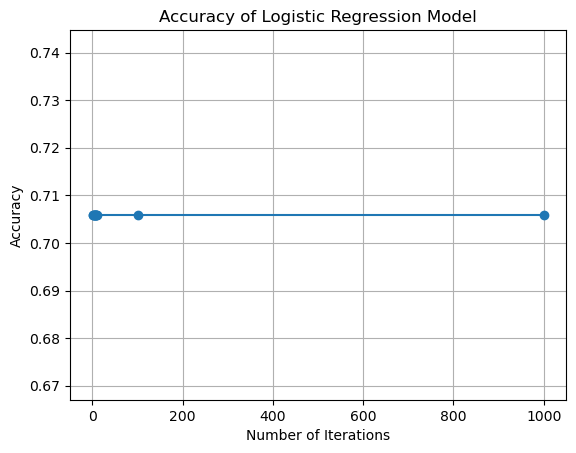

In [58]:
#Switch hyperparameters up
learning_rate = 0.001
num_iterations_list = [1,2,3,4,5,6,7,8,9,10, 100, 1000]

#Train the logistic regression model and evaluate accuracy for each number of iterations
accuracy_scores = []
for num_iterations in num_iterations_list:
    #Training step
    weights, bias = logistic_regression(X_train, y_train, learning_rate, num_iterations)
    
    #Make predictions on the test data
    y_pred = logistic_regression_predict(X_test, weights, bias)
    
    #Calculate accuracy
    acc = compute_score(y_test, y_pred)
    print("Accuracy: {:.2f}%".format(acc* 100))
    accuracy_scores.append(acc)

#Plot accuracy over iterations
plt.plot(num_iterations_list, accuracy_scores, marker='o')
plt.xlabel('Number of Iterations')
plt.ylabel('Accuracy')
plt.title('Accuracy of Logistic Regression Model')
plt.grid(True)
plt.show()

In [56]:
#Evaluate coefficients
print(weights)
print(np.argsort(weights)[-13:])

#Features selected shared with Gradient Boosting
#GATS8s
#
print(features[1191])
print(weights[1191])
print(features[742])
print(weights[742])
print(features[739])
print(weights[739])
print(features[643])
print(weights[643])
print(features[1080])
print(weights[1080])
print(features[839])
print(weights[839])
print(features[424])
print(weights[424])
print(features[738])
print(weights[738])
print(features[271])
print(weights[271])
print(features[645])
print(weights[645])
print(features[43])
print(weights[43])
print(features[1192])
print(weights[1192])
print(features[495])
print(weights[495])

#NCBI Selected 13
#MDEC23
#MATS2v
#ATSC8s
#VE3Dt
#CrippenMR
#SpMax7_Bhe
#SpMin1_Bhs
#C1SP2
#GATS8e
#GATS8s
#SpMax5_Bhv
#VE3_Dzi
#VPC-4

#Logistic regression found 1 
#GATS8s

print(weights.shape)

[-0.0335177  -0.04601429 -0.01793141 ...  0.00832843  0.01031035
  0.07375946]
[  52  562 1042  911  271 1202  738  335 1044 1191  645 1192  495]
WTPT-1
0.08129705104723178
JGI9
0.038532591978256286
JGI4
0.04155088419564341
khs.dssC
0.05712714290261922
GATS8s
0.056129566436339255
nAtomLAC
0.06083295915101639
BCUTw-1l
0.05613706828774782
JGI7
0.07473258344844018
minaasC
0.07307616003001315
EE_Dt
0.08371932022201944
minssCH2
0.06320139932283148
WTPT-2
0.11529782650759661
nG
0.1201113491035559
(1203,)


In [59]:
def custom_rfe(X, y, learning_rate, num_iterations, n_features_to_select):
    remaining_features = list(range(X.shape[1]))
    selected_features = []
    
    while len(selected_features) < n_features_to_select:
        scores = []
        for feature in remaining_features:
            features_subset = selected_features + [feature]
            X_subset = X[:, features_subset]
            
            #Training
            weights, bias = logistic_regression(X_subset, y, learning_rate, num_iterations)
            
            #Prediction
            y_pred = logistic_regression_predict(X_subset, weights, bias)
            
            #Accuracy
            acc = compute_score(y, y_pred)
            scores.append((acc, feature))
        
        scores.sort(reverse=True)
        best_acc, best_feature = scores.pop(0)
        selected_features.append(best_feature)
        remaining_features.remove(best_feature)
        print(f'Selected Features: {selected_features}, Accuracy: {best_acc}')
    
    return selected_features


In [62]:
selected_features = custom_rfe(X_train, y_train, 0.01, 1000, 13)

Selected Features: [1184], Accuracy: 0.6861313868613139
Selected Features: [1184, 334], Accuracy: 0.7226277372262774
Selected Features: [1184, 334, 164], Accuracy: 0.7299270072992701
Selected Features: [1184, 334, 164, 884], Accuracy: 0.7518248175182481
Selected Features: [1184, 334, 164, 884, 1168], Accuracy: 0.7664233576642335
Selected Features: [1184, 334, 164, 884, 1168, 657], Accuracy: 0.7883211678832117
Selected Features: [1184, 334, 164, 884, 1168, 657, 1200], Accuracy: 0.7956204379562044
Selected Features: [1184, 334, 164, 884, 1168, 657, 1200, 922], Accuracy: 0.8029197080291971
Selected Features: [1184, 334, 164, 884, 1168, 657, 1200, 922, 80], Accuracy: 0.8102189781021898
Selected Features: [1184, 334, 164, 884, 1168, 657, 1200, 922, 80, 1194], Accuracy: 0.8102189781021898
Selected Features: [1184, 334, 164, 884, 1168, 657, 1200, 922, 80, 1194, 1192], Accuracy: 0.8102189781021898
Selected Features: [1184, 334, 164, 884, 1168, 657, 1200, 922, 80, 1194, 1192, 1190], Accuracy: 0

In [70]:
X = data.drop(columns=['Class'])
true_indices = np.array([1184, 334, 164, 884, 1168, 657, 1200, 922, 80, 1194, 1192, 1190, 1185])

#Get the names of selected features
selected_features = X.columns[true_indices]

#Print the names of selected features
print("Names of selected features:")
print(selected_features)

#NCBI Selected 13
#MDEC23
#MATS2v
#ATSC8s
#VE3Dt
#CrippenMR
#SpMax7_Bhe
#SpMin1_Bhs
#C1SP2
#GATS8e
#GATS8s
#SpMax5_Bhv
#VE3_Dzi
#VPC-4

#Sklearn found:
#Index(['SpMax4_Bhm', 'MATS7v', 'maxssNH', 'MATS6s', 'ATSC2e', 'minsF',
#      'MDEN-22', 'VR1_Dt', 'ATSC5e', 'ATSC5m', 'AATSC6e', 'SsF',
#      'SpMax5_Bhm'],

Names of selected features:
Index(['AATSC1v', 'MATS7v', 'SpMax4_Bhe', 'khs.tsC', 'GATS5c', 'nHBint3',
       'SHdNH', 'SHBint7', 'nFRing', 'WTPT-4', 'WTPT-2', 'ETA_Eta', 'AATSC1m'],
      dtype='object')


In [77]:
#Test different featuresets found by logreg and RTE

data = pd.read_csv('toxicity_data.csv')
#Extract the features and target variable
features_set1 = ['AATSC1v', 'MATS7v', 'SpMax4_Bhe', 'khs.tsC', 'GATS5c', 'nHBint3', 'SHdNH', 'SHBint7', 'nFRing', 'WTPT-4', 'WTPT-2', 'ETA_Eta', 'AATSC1m']
features_set2 = ['WTPT-1', 'JGI9', 'JGI4', 'khs.dssC', 'GATS8s', 'nAtomLAC', 'BCUTw-1l', 'JGI7', 'minaasC', 'EE_Dt', 'minssCH2', 'WTPT-2', 'nG']

#Toxicity data has class variable (toxic vs nontoxic) as target variable
X = data.drop('Class', axis=1) 
y = data['Class']
X = X.to_numpy()

#Convert target variable numeric
#0 FOR NONTOXIC
#1 FOR TOXIC
y_numeric = [0 if label == 'NonToxic' else 1 for label in y]
#Convert to numpy array
y_numeric = np.array(y_numeric)

X_train, X_test, y_train, y_test = train_test_split(X, y_numeric, test_size=0.2, random_state=42)
#Test train/test split
print("Shape of X_train:", X_train.shape)
print("Shape of X_test:", X_test.shape)
print("Shape of y_train:", y_train.shape)
print("Shape of y_test:", y_test.shape)

#Normalize TEST using custom standard scaler function
X_train = standard_scaler(X_train)
X_test = standard_scaler(X_test)

Shape of X_train: (137, 1203)
Shape of X_test: (34, 1203)
Shape of y_train: (137,)
Shape of y_test: (34,)


C:\Users\Brian\AppData\Local\Temp\ipykernel_34968\1123484564.py:68: RuntimeWarning: invalid value encountered in divide
  scaled_X = (X - means) / stds


In [86]:
#Set hyperparameters for logistic regression
learning_rate = 0.01
num_iterations = 1000

#Train two logistic regression models
weights_set1, bias_set1 = logistic_regression(X_train[:, [list(data.columns).index(feature) for feature in features_set1]], y_train, learning_rate, num_iterations)
weights_set2, bias_set2 = logistic_regression(X_train[:, [list(data.columns).index(feature) for feature in features_set2]], y_train, learning_rate, num_iterations)

y_pred_set1 = logistic_regression_predict(X_test[:, [list(data.columns).index(feature) for feature in features_set1]], weights_set1, bias_set1)
y_pred_set2 = logistic_regression_predict(X_test[:, [list(data.columns).index(feature) for feature in features_set2]], weights_set2, bias_set2)

accuracy_set1 = compute_score(y_test, y_pred_set1)
accuracy_set2 = compute_score(y_test, y_pred_set2)

#Compare accuracy of different feature sets
print("Accuracy using features set 1:", accuracy_set1)
print("Accuracy using features set 2:", accuracy_set2)

Accuracy using features set 1: 0.7058823529411765
Accuracy using features set 2: 0.6764705882352942
